In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False
from sklearn.model_selection      import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing       import StandardScaler
from sklearn.impute              import SimpleImputer
from xgboost                     import XGBClassifier
from sklearn.metrics             import confusion_matrix, classification_report
from sklearn.pipeline            import Pipeline
from sklearn.metrics             import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 경고 메시지 억제
import warnings
warnings.filterwarnings('ignore')  

In [2]:
# 데이터 로드 및 ID 제거
df = pd.read_csv("final_features.csv")
X = df.drop(columns=['Segment', 'ID'])
y = df['Segment']

# E vs not-E 이진 타깃 생성
y_e = (y == 'E').astype(int)

# 학습/검증 분할 (20% 검증, E 분포 유지)
X_train, X_val, y_train_e, y_val_e, y_train, y_val = train_test_split(
    X, y_e, y, test_size=0.2, random_state=42, stratify=y_e
)

# 스케일러 학습 및 변환
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)

In [3]:
# 1. 모델1: E vs not-E 분류
model1 = XGBClassifier(eval_metric='logloss', random_state=42, verbose=-1, verbosity=0, tree_method='gpu_hist', predictor = 'gpu_predictor')

# E vs not-E
model1.fit(X_train_s, y_train_e)

# 검증셋 E vs not-E
y1_pred = model1.predict(X_val_s)

print("=== 모델1: E vs not-E ===")
print(confusion_matrix(y_val_e, y1_pred))
print(classification_report(y_val_e, y1_pred, target_names=['not-E','E']))

# 검증셋 DataFrame 및 pred1 추가
df_val = pd.DataFrame(X_val_s, columns=X.columns)
df_val['true_seg'] = y_val.values
df_val['pred1']    = y1_pred

=== 모델1: E vs not-E ===
[[11088  4844]
 [ 2631 61437]]
              precision    recall  f1-score   support

       not-E       0.81      0.70      0.75     15932
           E       0.93      0.96      0.94     64068

    accuracy                           0.91     80000
   macro avg       0.87      0.83      0.85     80000
weighted avg       0.90      0.91      0.90     80000



In [4]:
# 2. 모델2: A/B vs C/D 분류

# pred1 == 0 (not-E) 데이터
df_val_notE = df_val[df_val['pred1'] == 0].reset_index(drop=True)
X_val_notE  = df_val_notE[X.columns]

# A/B vs C/D 레이블 (A,B→1 / C,D→0)
y2_true = df_val_notE['true_seg'].apply(lambda s: 1 if s in ['A','B'] else 0)

# 학습셋 not-E 샘플 및 A/B vs C/D 타깃
mask_train_notE = (y_train_e == 0)
X_train_notE    = X_train_s[mask_train_notE]
y_train_notE    = y_train[mask_train_notE].apply(lambda s: 1 if s in ['A','B'] else 0)

# XGBoost 분류기 
model2 = XGBClassifier(eval_metric='logloss', random_state=42, verbose=-1, verbosity=0, tree_method='gpu_hist', predictor = 'gpu_predictor')

# A/B vs C/D
model2.fit(X_train_notE, y_train_notE)

# 검증셋 A/B vs C/D
y2_pred = model2.predict(X_val_notE)

print("\n=== 모델2: A/B vs C/D ===")
print(confusion_matrix(y2_true, y2_pred))
print(classification_report(y2_true, y2_pred, target_names=['C/D','A/B']))

# pred2 컬럼
df_val_notE['pred2'] = y2_pred


=== 모델2: A/B vs C/D ===
[[13680     2]
 [   32     5]]
              precision    recall  f1-score   support

         C/D       1.00      1.00      1.00     13682
         A/B       0.71      0.14      0.23        37

    accuracy                           1.00     13719
   macro avg       0.86      0.57      0.61     13719
weighted avg       1.00      1.00      1.00     13719



In [5]:
# 모델3: A vs B 분류
# pred2 == 1 (A/B로 예측된) 데이터
df_val_AB = df_val_notE[df_val_notE['pred2'] == 1].reset_index(drop=True)
X_val_AB  = df_val_AB[X.columns]

# A vs B 레이블 (B→1 / A→0)
y3_true = df_val_AB['true_seg'].apply(lambda s: 1 if s == 'B' else 0)

# 학습셋 A/B 샘플 및 A vs B 타깃
mask_train_AB = mask_train_notE & (y_train.isin(['A','B']))
X_train_AB    = X_train_s[mask_train_AB]
y_train_AB    = y_train[mask_train_AB].apply(lambda s: 1 if s == 'B' else 0)

# XGBoost 분류기 
model3 = XGBClassifier(eval_metric='logloss', random_state=42, verbose=-1, verbosity=0, tree_method='gpu_hist', predictor = 'gpu_predictor')

# A vs B
model3.fit(X_train_AB, y_train_AB)

# 검증셋 A vs B
y3_pred = model3.predict(X_val_AB)

print("\n=== 모델3: A vs B ===")
print(confusion_matrix(y3_true, y3_pred))
print(classification_report(y3_true, y3_pred, labels=[0,1], target_names=['A','B']))


=== 모델3: A vs B ===
[[7]]
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         7
           B       0.00      0.00      0.00         0

    accuracy                           1.00         7
   macro avg       0.50      0.50      0.50         7
weighted avg       1.00      1.00      1.00         7



In [6]:
# 4. 모델4: C vs D 분류
# pred2 == 0 (C/D로 예측된) 데이터
df_val_CD = df_val_notE[df_val_notE['pred2'] == 0].reset_index(drop=True)
X_val_CD  = df_val_CD[X.columns]

# C vs D 레이블 (D→1 / C→0)
y4_true = df_val_CD['true_seg'].apply(lambda s: 1 if s == 'D' else 0)

# 학습셋 C/D 샘플 및 C vs D 타깃
mask_train_CD = mask_train_notE & (y_train.isin(['C','D']))
X_train_CD    = X_train_s[mask_train_CD]
y_train_CD    = y_train[mask_train_CD].apply(lambda s: 1 if s == 'D' else 0)

# XGBoost 분류기 
model4 = XGBClassifier(eval_metric='logloss', random_state=42, verbose=-1, verbosity=0, tree_method='gpu_hist', predictor = 'gpu_predictor')

# C vs D
model4.fit(X_train_CD, y_train_CD)

# 검증셋 C vs D
y4_pred = model4.predict(X_val_CD)

print("\n=== 모델4: C vs D ===")
print(confusion_matrix(y4_true, y4_pred))
print(classification_report(y4_true, y4_pred, target_names=['C','D']))


=== 모델4: C vs D ===
[[2416 4006]
 [ 777 6513]]
              precision    recall  f1-score   support

           C       0.76      0.38      0.50      6422
           D       0.62      0.89      0.73      7290

    accuracy                           0.65     13712
   macro avg       0.69      0.63      0.62     13712
weighted avg       0.68      0.65      0.62     13712



### 최종 결과

=== 최종 모델 통합 성능 평가 (A/B/C/D/E) ===
              precision    recall  f1-score   support

           A       0.71      0.16      0.26        32
           B       0.00      0.00      0.00         5
           C       0.68      0.50      0.58      4317
           D       0.62      0.56      0.59     11578
           E       0.93      0.96      0.94     64068

    accuracy                           0.88     80000
   macro avg       0.59      0.44      0.47     80000
weighted avg       0.87      0.88      0.87     80000



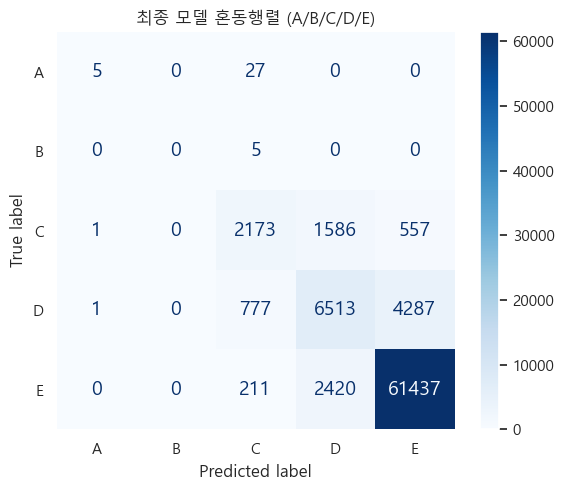

In [7]:
# 1. E로 예측된 고객
df_pred_E = df_val[df_val['pred1'] == 1].copy()
df_pred_E['final_pred'] = 'E'

# 2. A/B로 예측된 고객
df_pred_AB = df_val_notE[df_val_notE['pred2'] == 1].copy()
df_pred_AB['final_pred'] = np.where(y3_pred == 1, 'B', 'A')

# 3. C/D로 예측된 고객
df_pred_CD = df_val_notE[df_val_notE['pred2'] == 0].copy()
df_pred_CD['final_pred'] = np.where(y4_pred == 1, 'D', 'C')

# 모두 합치기
df_val_all = pd.concat([df_pred_E, df_pred_AB, df_pred_CD], axis=0).reset_index(drop=True)

# 평가
y_true_final = df_val_all['true_seg']
y_pred_final = df_val_all['final_pred']

print("=== 최종 모델 통합 성능 평가 (A/B/C/D/E) ===")
print(classification_report(y_true_final, y_pred_final, labels=['A','B','C','D','E']))

# 혼동행렬 시각화
labels = ['A', 'B', 'C', 'D', 'E']
cm = confusion_matrix(y_true_final, y_pred_final, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=True)

# 그리드(격자) 끄기
ax.grid(False)

# 축 테두리(스파인) 숨기기
for spine in ax.spines.values():
    spine.set_visible(False)

plt.title("최종 모델 혼동행렬 (A/B/C/D/E)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

In [8]:
# 제출 양식과 PCA 완료된 TEST 피처 불러오기
sample_sub     = pd.read_csv("sample_submission.csv")
test_feat_df   = pd.read_csv("final_test_features.csv")  

# ID 분리, 피처만 남기기
test_ids       = test_feat_df['ID']
X_test_final   = test_feat_df.drop(columns=['ID'])

# 계층형 모델 예측
final_preds = []
for x in X_test_final.values:
    # E vs not-E
    if model1.predict([x])[0] == 1:
        final_preds.append('E')
    else:
        # A/B vs C/D
        if model2.predict([x])[0] == 1:
            # A vs B
            final_preds.append('B' if model3.predict([x])[0] == 1 else 'A')
        else:
            # C vs D
            final_preds.append('D' if model4.predict([x])[0] == 1 else 'C')

# 예측 결과를 sample_sub에 채워 저장
sample_sub['Segment'] = final_preds
sample_sub['Segment']

0        C
1        D
2        D
3        E
4        E
        ..
99995    E
99996    E
99997    E
99998    C
99999    E
Name: Segment, Length: 100000, dtype: object

In [9]:
sample_sub.to_csv("submission.csv", index=False, encoding="utf-8-sig")